# ML Modelling - Raízen Technical Chellenge


### First things first: Problem Definition
Before we start thinking about our super random forests, hiper xgboosts and amazing neural nets (it is a try to make things funny haha), we need to define what we are going to model here. Given that, this is what our model must do:

**Predict the next day sum of people usage per each combination of station and line**

With this definition, we can now say that we have a timeseries problem and it brings some implications. With a timeseries, we will not shuffle our data in the cross validation and the split between train and test sets. To make our cross validation proceess, we will use sklearn timeseries cross validation:

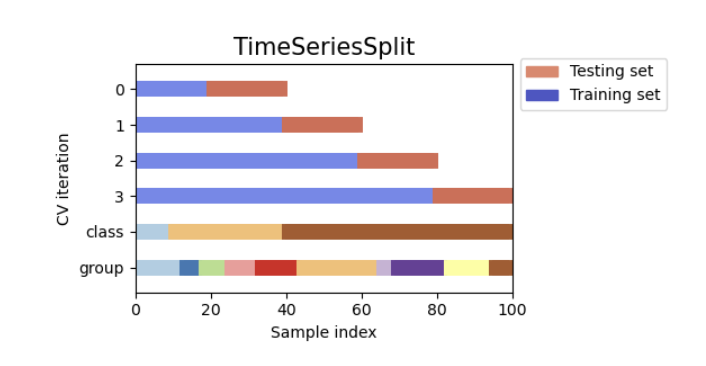
Source: sklearn documentation.

For the train and test split, we will do the following: Our model will be trained with data from 2010 to 2016 and we will use 2017 for vlidation.


### Development
In this notebook, we will perform all the tasks involved in a machine learning model bulding process. Here, we are gonna do:

1. Baseline model;
2. Model after feature engineering;
3. Hyperparameter tunning.

In [1]:
#session setup
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import VotingRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading data
data = pd.read_csv("../dados_desafio/prepared_data.csv")
data.head(3)

,date,station,linename,entries,exits,real_entries,real_exits,people_flow
0,2010-04-17,1 AVE,L,265071111.0,224481314.0,8179.0,9088.0,17267.0
1,2010-04-17,103 ST,1,195542531.0,106410762.0,6570.0,2408.0,8978.0
2,2010-04-17,103 ST,6,144693237.0,150159494.0,6740.0,5891.0,12631.0


In [3]:
#let's guarantee that our dataset is sorted by date
#this is essential for our problem definition
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

#sorting
data = data.sort_values(by="date", ascending=True)

In [4]:
#converting our dataset in a time series problem for next day prediction
data["target"] = data.groupby(["station", "linename"])["people_flow"].shift(-1)

#our shift process generates some missing values in the end of the dataset but it is not relevant
#beacuse the tail part of our dataset is goin to be used just for validation
data = data.dropna(subset="target")

### Lazy baseline
To set a minimum model performance, we will compare our machine learning models with the simplest model possible: we will use the value for today as a prediction of the value tomorrow.

In [5]:
#lazy baseline model
y_real = data["target"].values
y_lazy = data["people_flow"].values

#results - mse
mae_base = mean_absolute_error(y_real, y_lazy)

print(f"lazy baseline mean absolute error: {mae_base}")

lazy baseline mean absolute error: 3749.1680120213487


In [5]:
#converting category to num
data["station"] = data["station"].astype("category").cat.codes
data["linename"] = data["linename"].astype("category").cat.codes

Tree-based models use a kind of categorization of all features when creating the decision nodes. Because of that, we will use only label encoder. We will not use one hot encoder because we trust the capacity of tree-based models naturally deal with categorical features and because the cardinality of our categorical features would make it almost impossible.

**Tree model "categorization" example**
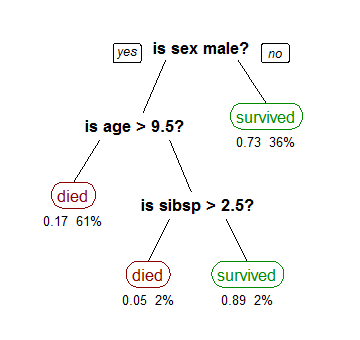

In [6]:
#creating year column
data["year"] = data["date"].dt.year

#split data
data_train = data[data["year"] < 2017]
data_val = data[data["year"] == 2017]

# Baseline model

Let's try a model with zero feature engineering and deafault parameters of a catboost regressor

In [7]:
#creating X_train and y_train
X_train, y_train = data_train.drop(columns="target", axis=1), data_train.target.values

In [9]:
#checking X_train columns
X_train.columns

Index(['date', 'station', 'linename', 'entries', 'exits', 'real_entries',
       'real_exits', 'people_flow', 'year'],
      dtype='object')

In [8]:
#we will drop come columns we will not use as features
X_train = X_train.drop(columns=["date", "people_flow", "year"], axis=1)

In [21]:
#initializing our timeseries split
tscv = TimeSeriesSplit(n_splits=3)

In [12]:
#converting data to numpy to reduce our computational costs on the training process
X_train_array = X_train.to_numpy()

In [13]:
#initializing our algorithm
model = XGBRegressor()

In [14]:
#calculating cross validation scores
scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error")

print("Cross-validation scores:", scores)

Cross-validation scores: [-6130.4184455  -4012.98938851 -4053.07339991]


### Feature Engineering

Now we are going to perform some feature engineering to see if we can improve these results

In [7]:
#day of week
data["day_of_week"] = data["date"].dt.dayofweek

In [8]:
#month_year
data["month"] = data["date"].dt.month
data["month_year"] = data["month"].astype("str") + "_" + data["year"].astype("str")
data.head(3)

,date,station,linename,entries,exits,real_entries,real_exits,people_flow,target,year,day_of_week,month,month_year
0,2010-04-17,1,103,265071111.0,224481314.0,8179.0,9088.0,17267.0,34261.0,2010,5,4,4_2010
321,2010-04-17,374,35,83265045.0,73706270.0,813.0,563.0,1376.0,1822.0,2010,5,4,4_2010
320,2010-04-17,372,40,49279524.0,45564352.0,1778.0,820.0,2598.0,3493.0,2010,5,4,4_2010


In [9]:
#week_year
data["week"] = data["date"].dt.isocalendar().week
data["week_year"] = data["week"].astype("str") + "_" + data["year"].astype("str")
data.head(3)

,date,station,linename,entries,exits,real_entries,real_exits,people_flow,target,year,day_of_week,month,month_year,week,week_year
0,2010-04-17,1,103,265071111.0,224481314.0,8179.0,9088.0,17267.0,34261.0,2010,5,4,4_2010,15,15_2010
321,2010-04-17,374,35,83265045.0,73706270.0,813.0,563.0,1376.0,1822.0,2010,5,4,4_2010,15,15_2010
320,2010-04-17,372,40,49279524.0,45564352.0,1778.0,820.0,2598.0,3493.0,2010,5,4,4_2010,15,15_2010


In [26]:
#converting new categorical features to numerical
data["month_year"] = data["month_year"].astype("category").cat.codes
data["week_year"] = data["week_year"].astype("category").cat.codes

In [11]:
#new split
data_train = data[data["year"] < 2017]
data_val = data[data["year"] == 2017]

In [12]:
#creating X_train and y_train
X_train, y_train = data_train.drop(columns="target", axis=1), data_train.target.values

In [13]:
#we will drop come columns we will not use as features
X_train = X_train.drop(columns=["date", "year"], axis=1)

In [22]:
#converting data to numpy to reduce our computational costs on the training process
X_train_array = X_train.to_numpy()

In [23]:
#calculating cross validation scores
scores = cross_val_score(model, X_train_array, y_train, cv=tscv, scoring="neg_mean_absolute_error")

print("Cross-validation scores:", scores)

Cross-validation scores: [-2194.97135722 -2364.5748013  -2273.88719329]


We were able to significantly improve our results. Beyond the error reduction, we were also able to achive a better satability in our results: all the three folds have a similar level of error, what show us that we have a model without interference of overfitting.

**More feature engineering**

Now will push a little bit more our feature engineering process to see how far we can go. We will use a customized sklearn fit/transform type of class created by me. This class basically creates statiscs per groups. Note that these statistics muste be calculated only on the training set, thats why we need a a fit method. This class was already built in a private repository on my github and I am just giving a try to my creation to see if it can help me here haha.

We will also recreate all the previous preparation steps because now we are in a new kernel session.

In [2]:
#loading data
data = pd.read_csv("../dados_desafio/prepared_data.csv")
data.head(3)

,date,station,linename,entries,exits,real_entries,real_exits,people_flow
0,2010-04-17,1 AVE,L,265071111.0,224481314.0,8179.0,9088.0,17267.0
1,2010-04-17,103 ST,1,195542531.0,106410762.0,6570.0,2408.0,8978.0
2,2010-04-17,103 ST,6,144693237.0,150159494.0,6740.0,5891.0,12631.0


In [3]:
#let's guarantee that our dataset is sorted by date
#this is essential for our problem definition
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

#sorting
data = data.sort_values(by="date", ascending=True)

In [4]:
#converting our dataset in a time series problem for next day prediction
data["target"] = data.groupby(["station", "linename"])["people_flow"].shift(-1)

#our shift process generates some missing values in the end of the dataset but it is not relevant
#beacuse the tail part of our dataset is goin to be used just for validation
data = data.dropna(subset="target")

In [5]:
#converting category to num
data["station"] = data["station"].astype("category").cat.codes
data["linename"] = data["linename"].astype("category").cat.codes

#we are having problems with xgboost when using category as dtypes
#so we will convert our codes back to int
data["station"] = data["station"].astype("int")
data["linename"] = data["linename"].astype("int")

In [6]:
#creating year column
data["year"] = data["date"].dt.year

In [7]:
#day of week
data["day_of_week"] = data["date"].dt.dayofweek

In [8]:
#month_year
data["month"] = data["date"].dt.month
data["month_year"] = data["month"].astype("str") + "_" + data["year"].astype("str")
data.head(3)

,date,station,linename,entries,exits,real_entries,real_exits,people_flow,target,year,day_of_week,month,month_year
0,2010-04-17,1,103,265071111.0,224481314.0,8179.0,9088.0,17267.0,34261.0,2010,5,4,4_2010
321,2010-04-17,374,35,83265045.0,73706270.0,813.0,563.0,1376.0,1822.0,2010,5,4,4_2010
320,2010-04-17,372,40,49279524.0,45564352.0,1778.0,820.0,2598.0,3493.0,2010,5,4,4_2010


In [9]:
#week_year
data["week"] = data["date"].dt.isocalendar().week
data["week"] = data["week"].astype("int")
data["week_year"] = data["week"].astype("str") + "_" + data["year"].astype("str")
data.head(3)

,date,station,linename,entries,exits,real_entries,real_exits,people_flow,target,year,day_of_week,month,month_year,week,week_year
0,2010-04-17,1,103,265071111.0,224481314.0,8179.0,9088.0,17267.0,34261.0,2010,5,4,4_2010,15,15_2010
321,2010-04-17,374,35,83265045.0,73706270.0,813.0,563.0,1376.0,1822.0,2010,5,4,4_2010,15,15_2010
320,2010-04-17,372,40,49279524.0,45564352.0,1778.0,820.0,2598.0,3493.0,2010,5,4,4_2010,15,15_2010


In [10]:
#converting new categorical features to numerical
data["month_year"] = data["month_year"].astype("category").cat.codes
data["week_year"] = data["week_year"].astype("category").cat.codes

#we are having problems with xgboost when using category as dtypes
#so we will convert our codes back to int
data["month_year"] = data["month_year"].astype("int")
data["week_year"] = data["week_year"].astype("int")

In [11]:
#new split
data_train = data[data["year"] < 2017]
data_val = data[data["year"] == 2017]

In [12]:
#creating X_train and y_train
X_train, y_train = data_train.drop(columns="target", axis=1), data_train.target.values

In [13]:
#we will drop come columns we will not use as features
X_train = X_train.drop(columns=["date", "year"], axis=1)

In [14]:
#initializing our timeseries split
tscv = TimeSeriesSplit(n_splits=3)

In [15]:
"""
=================================================
Classe para criar estatísticas entre agrupamentos
=================================================

Retorna um pandas dataframe com as colunas originais e as novas features calculadas.

:: Parâmetros
    ** group_columns (requerido): list
        Lista com o(s) nome da(s) coluna(s) que identifica(m) cada uma das múltiplas séries temporais.  
    ** features (requerido): list
        Lista com o nome das features que serão usadas como base para os cálculos estatísticos.

:: Exemplo:
-----------
    #Inicialização
    group_features = GroupFeatures(group_columns=["Forno"],
                        features=["temperatura", "pressao"])

    #fit
    group_features.fit(df_train)

    #transform
    df_train = group_features.transform(df_train)
    df_val = group_features.transform(df_val)
    df_test = group_features.transform(df_test)

:: OBSERVAÇÃO:
--------------
    Precisa que a divisão treino, validação e teste seja feita antes do uso dessa classe.
"""
class GroupFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, group_columns, features):
        self.group_columns = group_columns
        self.features = features
        
    def group_features(self, gp, vf, data):
        
        mean_names = []
        max_names = []
        min_names = []
        
        for f in vf:
            mean_name = f"{gp[0]}_{f}_mean"
            max_name = f"{gp[0]}_{f}_max"
            min_name = f"{gp[0]}_{f}_min"
            
            mean_names.append(mean_name)
            max_names.append(max_name)
            min_names.append(min_name)
            
        d_mean = dict(zip(vf, mean_names))
        d_max = dict(zip(vf, max_names))
        d_min = dict(zip(vf, min_names))
        
        df_group_mean = pd.DataFrame(data.groupby(gp)[vf[:]].mean().rename(columns=d_mean))
        df_group_mean = df_group_mean.reset_index()
        
        df_group_max = pd.DataFrame(data.groupby(gp)[vf[:]].max().rename(columns=d_max))
        df_group_max = df_group_max.reset_index()
        
        df_group_min = pd.DataFrame(data.groupby(gp)[vf[:]].min().rename(columns=d_min))
        df_group_min = df_group_min.reset_index()
        
        return df_group_mean, df_group_max, df_group_min
    
    def fit(self, X, y=None):
        self.group_dataframes = self.group_features(self.group_columns, self.features, X)
        return self
                                    
    def transform(self, X):
                         
        # Accessing the dataframes from the stored object
        df_group_mean, df_group_max, df_group_min = self.group_dataframes
        
        # Creating the final dataframe
        X_final = X.merge(df_group_mean, on=self.group_columns, how="left")
        X_final = X_final.merge(df_group_max, on=self.group_columns, how="left")
        X_final = X_final.merge(df_group_min, on=self.group_columns, how="left")
                                    
        for value_feature in self.features:
            X_final[f"{value_feature}/{self.group_columns[0]}_mean"] = X_final[f"{value_feature}"] / X_final[f"{self.group_columns[0]}_{value_feature}_mean"]
            X_final[f"{value_feature}/{self.group_columns[0]}_max"] = X_final[f"{value_feature}"] / X_final[f"{self.group_columns[0]}_{value_feature}_max"]
            X_final[f"{value_feature}/{self.group_columns[0]}_min"] = X_final[f"{value_feature}"] / ((X_final[f"{self.group_columns[0]}_{value_feature}_min"]**2)+10)
                                    
        return X_final

In [16]:
#instatiating some variables that we will use in our custom transform
gp1 = ["linename"]
gp2 = ["station"]
features = ["real_entries", "real_exits", "people_flow"]

In [17]:
#we will need to use sklearn pipeline with this custom transforms
pipe = Pipeline(steps=[
    ("gpf1", GroupFeatures(group_columns=gp1, features=features)),
    ("gpf2", GroupFeatures(group_columns=gp2, features=features)),
    ("estimator", XGBRegressor())
])

In [18]:
#this time we will need to use X_train as dataframe because it is how our feature creation works
#calculating cross validation scores
scores = cross_val_score(pipe, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error")

print("Cross-validation scores:", scores)

Cross-validation scores: [ -2771.8787341   -2846.49866616 -22886.708357  ]


We added a lot of features and our model got even worse. We will then move on with only the features created in the first feature engineering process.

### Hyperparameter Tunning
Here we will search if other xgboost parameters can bring us better results. To do this, we will use a grid of a few range of parameters and RandomizedSearchCV. Both these definitions were set in order to spare some computational costs due the fact that we do not have powerful resources available for us to complete the challenge. 

Our grid of parameters for xgboost will be composed by the following:

1. **n_estimators:** The number of trees that will be trained in our algorithm. Our strategy here is going to be setting high values of this parameter to make our model more robust and try to apply some regularization with other parameters;

2. **max_depth:** How deep our trees are going to be. We will try to not let this parameter too high to avoid overfitting in our model;

3. **subsample:** At each iteration, our algorithm will take a sample of our data to train a tree. If it is set to 1 (default), all algorithm uses the whole dataset. In this case, we will try lower values to prevent overfitting, given that we will try big numbers of estimators;

4. **lambda:** L2 regularization. Again, our idea here is to avoid overfitting given ou number of estimators.

From now on, we will reproduce the previous preparation steps because we are in a new kernel session.

In [2]:
#loading data
data = pd.read_csv("../dados_desafio/prepared_data.csv")
data.head(3)

,date,station,linename,entries,exits,real_entries,real_exits,people_flow
0,2010-04-17,1 AVE,L,265071111.0,224481314.0,8179.0,9088.0,17267.0
1,2010-04-17,103 ST,1,195542531.0,106410762.0,6570.0,2408.0,8978.0
2,2010-04-17,103 ST,6,144693237.0,150159494.0,6740.0,5891.0,12631.0


In [3]:
#let's guarantee that our dataset is sorted by date
#this is essential for our problem definition
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

#sorting
data = data.sort_values(by="date", ascending=True)

In [4]:
#converting our dataset in a time series problem for next day prediction
data["target"] = data.groupby(["station", "linename"])["people_flow"].shift(-1)

#our shift process generates some missing values in the end of the dataset but it is not relevant
#beacuse the tail part of our dataset is goin to be used just for validation
data = data.dropna(subset="target")

In [5]:
#converting category to num
data["station"] = data["station"].astype("category").cat.codes
data["linename"] = data["linename"].astype("category").cat.codes

In [6]:
#creating year column
data["year"] = data["date"].dt.year

In [7]:
#day of week
data["day_of_week"] = data["date"].dt.dayofweek

In [8]:
#month_year
data["month"] = data["date"].dt.month
data["month_year"] = data["month"].astype("str") + "_" + data["year"].astype("str")
data.head(3)

,date,station,linename,entries,exits,real_entries,real_exits,people_flow,target,year,day_of_week,month,month_year
0,2010-04-17,1,103,265071111.0,224481314.0,8179.0,9088.0,17267.0,34261.0,2010,5,4,4_2010
321,2010-04-17,374,35,83265045.0,73706270.0,813.0,563.0,1376.0,1822.0,2010,5,4,4_2010
320,2010-04-17,372,40,49279524.0,45564352.0,1778.0,820.0,2598.0,3493.0,2010,5,4,4_2010


In [9]:
#week_year
data["week"] = data["date"].dt.isocalendar().week
data["week_year"] = data["week"].astype("str") + "_" + data["year"].astype("str")
data.head(3)

,date,station,linename,entries,exits,real_entries,real_exits,people_flow,target,year,day_of_week,month,month_year,week,week_year
0,2010-04-17,1,103,265071111.0,224481314.0,8179.0,9088.0,17267.0,34261.0,2010,5,4,4_2010,15,15_2010
321,2010-04-17,374,35,83265045.0,73706270.0,813.0,563.0,1376.0,1822.0,2010,5,4,4_2010,15,15_2010
320,2010-04-17,372,40,49279524.0,45564352.0,1778.0,820.0,2598.0,3493.0,2010,5,4,4_2010,15,15_2010


In [10]:
#converting new categorical features to numerical
data["month_year"] = data["month_year"].astype("category").cat.codes
data["week_year"] = data["week_year"].astype("category").cat.codes

In [11]:
#new split
data_train = data[data["year"] < 2017]
data_val = data[data["year"] == 2017]

In [12]:
#saving data_val for posterior experiments
data_val.to_csv("../dados_desafio/eval_data.csv", index=False)

In [12]:
#creating X_train and y_train
X_train, y_train = data_train.drop(columns="target", axis=1), data_train.target.values

In [13]:
#we will drop come columns we will not use as features
X_train = X_train.drop(columns=["date", "year"], axis=1)

In [14]:
#converting data to numpy to reduce our computational costs on the training process
X_train_array = X_train.to_numpy()

In [15]:
#creating our parameter grid
grid = {"n_estimators": [300, 500, 600],
       "max_depth": [4, 6, 8],
       "subsample": [0.6, 0.8, 1.],
       "lambda": [2, 4, 6]}

In [16]:
#initializing our timeseries split
tscv = TimeSeriesSplit(n_splits=3)

In [17]:
#initializing our xgboost algorithm
model = XGBRegressor()

In [22]:
#setting our random search
search = RandomizedSearchCV(model, grid, cv=tscv, scoring="neg_mean_absolute_error")

In [23]:
#fit
search.fit(X_train_array, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=No...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   param_distributions={'lambda': [2, 4, 6],
                                        'max_depth': [4, 6, 8],
                                        'n_estimators': [300, 500, 600],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_absolute_error')

In [24]:
#checking the best parameters
search.best_params_

{'subsample': 1.0, 'n_estimators': 300, 'max_depth': 6, 'lambda': 6}

In [25]:
#checking results
df_results = pd.DataFrame(search.cv_results_)
df_results = df_results.sort_values(by="rank_test_score", ascending=True)

In [26]:
df_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,297.202018,126.676480,2.517514,0.024804,1.0,300,6,6,"{'subsample': 1.0, 'n_estimators': 300, 'max_d...",-2135.558376,-2217.621027,-2558.336010,-2303.838471,183.048842,1
2,679.617990,246.384634,5.267575,0.446143,0.6,600,6,6,"{'subsample': 0.6, 'n_estimators': 600, 'max_d...",-2160.470719,-2346.040203,-2425.324163,-2310.611695,110.990153,2
4,295.687965,124.120929,2.430116,0.041315,1.0,300,6,4,"{'subsample': 1.0, 'n_estimators': 300, 'max_d...",-2191.264563,-2294.592199,-2502.669559,-2329.508774,129.505839,3
8,313.724056,132.018032,2.482343,0.032123,0.8,300,6,4,"{'subsample': 0.8, 'n_estimators': 300, 'max_d...",-2206.274749,-2367.025557,-2523.791389,-2365.697232,129.629028,4
1,990.187340,437.491255,7.731238,0.324186,1.0,600,8,2,"{'subsample': 1.0, 'n_estimators': 600, 'max_d...",-2270.744217,-2269.655321,-2600.448929,-2380.282822,155.681582,5


Despite the efforts, our hyperparameter tunning process did not bring any improvement. It may happen due to the computational limitaion we have here because it does not allow us to iterate through many ranges of parameters. Some ways to deal with this could be:

1. More computational resources to try more combinations;
2. Use tools like optuna and hyperot to try a more assertive optimization problem.

### Ensemble

In a last try to improve our model, we are going to use our default model with 3 different seeds and put it all together in a voting regressor to see the results

In [15]:
#creating the 3 models
model1 = XGBRegressor(random_state=42)
model2 = XGBRegressor(random_state=111)
model3 = XGBRegressor(random_state=123)

In [16]:
#setting our voting regressor 
voting = VotingRegressor(estimators = [("model1", model1),
                                      ("model2", model2),
                                      ("model3", model3)])

In [17]:
#initializing our timeseries split
tscv = TimeSeriesSplit(n_splits=3)

In [18]:
#calculating cross validation scores
scores = cross_val_score(voting, X_train_array, y_train, cv=tscv, scoring="neg_mean_absolute_error")

print("Cross-validation scores:", scores)

Cross-validation scores: [-2194.97135546 -2364.57480002 -2273.88719134]


After all tries, we have not found anything to beat our default xgboost. Given that, we are ready to train our default model and move on to test it on the test set

In [19]:
#initializing the default algorithm
model = XGBRegressor()

In [20]:
#fit the model
model.fit(X_train_array, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
#creating X_test and y_test
X_test, y_test = data_val.drop(columns="target", axis=1), data_val.target.values

In [22]:
#we will drop come columns we will not use as features
X_test = X_test.drop(columns=["date", "year"], axis=1)

In [24]:
#converting to array
X_test_array = X_test.to_numpy()

In [25]:
#generating predictions
y_pred = model.predict(X_test_array)

In [26]:
#evaluation
mae = mean_absolute_error(y_test, y_pred)

print(f"test mean absolute error: {mae}")

test mean absolute error: 2275.1737775740485


This is good. Our result is similar to the cross validation metrics, then we can conclude our model has no overfitting.

In [27]:
#creating a percentage error
df_y = pd.DataFrame({"y_true": y_test,
                    "y_pred": y_pred})

#creating the column
df_y["percentage error"] = np.abs(df_y["y_true"] - df_y["y_pred"]) / df_y["y_true"]

In [28]:
#mean of percentage error
error = df_y["percentage error"].mean()

print(f"average percentage error: {error*100}%")

average percentage error: inf%


It looks like, for some data points, our error was absurdly huge. Let's take these errors out of the equation and see what happens.

In [33]:
#checking the shape before
df_y.shape

(125559, 3)

In [34]:
#removing inf
df_y = df_y[df_y["percentage error"] != np.inf]
df_y.shape

(125253, 3)

Ok, it has happend in only a few rows. Let's calculate the metric again.

In [36]:
#mean of percentage error
df_y["percentage error"].describe()

count    1.252530e+05
mean     7.467485e+00
std      1.623222e+02
min      5.192272e-07
25%      3.084494e-02
50%      7.714176e-02
75%      1.872580e-01
max      1.665549e+04
Name: percentage error, dtype: float64

The percentual error is a try to see how much an error represents compared to the real value .For our 75% percentile we have a good level of error. Above that, some strange things happen, but we may say that our model works well in a general way.

In [37]:
#saving model
joblib.dump(model, "../models/NYC_metro_model.pkl")

['../models/NYC_metro_model.pkl']

### Limitations

Our model has some limitations: 

1. The main one is related to the way that we dealt with the categorical features. The way that we did, we are assuming a critical assumption that, when in production, our model would not be able to deal with unknown categories. If in a real project this assumption could not have be taken, we would need to find alternatives;

2. We also got stuck in xgboost, but other algorithms like lgbm and catboost (talking only about boostings) could be experimented;

3. Our data consolidation needed to aggregate data with stations and line names by the mean of other variables. It may lead us to a loss of information, but it was an option to deal with our large memory usage by the big dataframes.